# Coin-M BTC DCA Ladder Strategy: Assumptions, Execution, and Robustness

This notebook implements and evaluates a Dollar-Cost-Averaging (DCA) ladder strategy on Bitcoin using coin-margined perpetual futures mechanics.

Key features:
- Deterministic fills (no randomness)
- Coin-margined funding fees applied in coin units
- Liquidation derived from wallet balance and maintenance margin
- Dynamic leverage cap tied to wallet balance
- Commissions and slippage costs
- Performance and risk metrics (Sharpe, Sortino, Calmar, Max Drawdown, VaR/ES)
- Clean plots and cycle-level reporting

### 1) Quick start

- Run all cells top-to-bottom to reproduce the in-sample (IS) and out-of-sample (OOS) results.
- Inputs
  - Data: BTC-USD daily OHLC from BTC-USD_Historical.csv (2015+)
  - Funding: constant daily rate unless a series is provided
- Outputs
  - Summary metrics (Sharpe, Sortino, Calmar, MDD, VaR/ES)
  - Equity curve + drawdowns
  - Cycle-level diagnostics (start/liquidation thresholds)

In [1]:
import math
from dataclasses import dataclass
from typing import Optional, Dict, Any, List, Tuple
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from cycles import compute_previous_cycle_ath, compute_objective_end_date, next_halving_date
from mechanics import (
    usd_notional_from_btc_margin,
    commission_btc_from_usd,
    funding_btc_from_usd,
    avg_entry_inverse_harmonic,
    liquidation_price_inverse,
    apply_slippage,
    max_position_btc
)
from buying_strategy import ladder
from metrics import compute_drawdowns, sortino_ratio, sharpe_ratio, lo_variance_inflation, adjusted_sharpe_lo, summarize_performance, var_es

  ### 2) Data & preprocessing

- Source: BTC-USD daily OHLC (CSV). Columns used: Date, Open, High, Low, Close.
- Date handling: parsed to UTC-like daily timestamps and sorted.
- History window: clipped to >= 2015-01-01 to support long SMAs and prior-cycle ATH logic.
- Note: If you prefer live retrieval, replace the CSV load with a yfinance download cell (and save to CSV for reproducibility).

In [2]:
# Load full history once
PRICE_CSV_PATH = "BTC-USD_Historical.csv"  # adjust path as needed
price_all = pd.read_csv(PRICE_CSV_PATH)
price_all['Date'] = pd.to_datetime(price_all['Date'])
price_all = price_all.sort_values('Date').reset_index(drop=True)

price_all.head()

# Set the cycle start (e.g., halving date for the IS cycle)
START_DATE = pd.Timestamp('2020-05-11')

# Ensure enough history before START_DATE to compute long weekly SMA and prior-cycle ATH
price_all = price_all[price_all['Date'] >= '2015-01-01'].sort_values('Date').reset_index(drop=True)

### 3) Cycle windows (IS & OOS)

- In-sample (IS): from START_DATE (e.g., halving) to an objective end date derived from:
  - Prior-cycle ATH and a weekly SMA regime filter (configurable)
- Out-of-sample (OOS): from the next halving date to +6 months (clipped to available data)
- Rationale: avoids using future information for IS and provides a clean, time-based OOS check.

In [3]:
END_DATE = compute_objective_end_date(price_all, START_DATE, weekly_sma_window=150, weekly_rule='W-SUN')

# Build IS window (this cycle only)
price = price_all[(price_all['Date'] >= START_DATE) & (price_all['Date'] <= END_DATE)].reset_index(drop=True)
print(f"Backtest IS window: {price['Date'].iloc[0].date()} -> {price['Date'].iloc[-1].date()} (objective end-date)")

# Halving dates (UTC close-of-day approximations). Adjust if you prefer exchange timestamps.
HALVING_DATES = [
    pd.Timestamp('2012-11-28'),
    pd.Timestamp('2016-07-09'),
    pd.Timestamp('2020-05-11'),
    pd.Timestamp('2024-04-20'),  # 2024 halving (approx)
]

OOS_START_DATE = next_halving_date(START_DATE, HALVING_DATES)
if OOS_START_DATE is None:
    print("No halving after START_DATE found in HALVING_DATES; OOS window cannot be built.")
    price_oos = pd.DataFrame()
else:
    OOS_END_DATE = OOS_START_DATE + pd.DateOffset(months=6)
    last_available = price_all['Date'].max()
    if OOS_START_DATE > last_available:
        print(f"OOS start {OOS_START_DATE.date()} is beyond available data ending {last_available.date()}. OOS window empty.")
        price_oos = pd.DataFrame()
    else:
        # Clip OOS end to available data
        OOS_END_DATE = min(OOS_END_DATE, last_available)
        price_oos = price_all[(price_all['Date'] >= OOS_START_DATE) & (price_all['Date'] <= OOS_END_DATE)].reset_index(drop=True)
        print(f"OOS window: {price_oos['Date'].iloc[0].date()} -> {price_oos['Date'].iloc[-1].date()} (next halving + 6 months)")

Objective end-date rule: prev cycle ATH=19,497.40 USD; end_date=2021-10-24
Backtest IS window: 2020-05-11 -> 2021-10-24 (objective end-date)
OOS window: 2024-04-20 -> 2024-10-20 (next halving + 6 months)


### 4) Configuration guide

Key parameters (see fields in StrategyConfig):
- initial_margin_btc: Seed collateral (BTC) per cycle
- leverage_limit: Max leverage multiple for sizing
- open_margin_pct: Fraction of initial margin used for the first entry
- take_profit_pct: Close the position when gain ≥ this fraction
- commission_rate, slippage_bps: Applied to every fill (entry/scale/exit)
- constant_funding_daily: Daily funding (fallback if no series is supplied)
- maintenance_margin_rate: Used in liquidation calculations
- stop_on_liquidation: Stop trading for the cycle if liquidation occurs
- forced_close_on_last_day: Force an exit on the last day of the window
- contract_model: 'inverse' (BTC-margined perp) or 'linear' (simplified path)

In [4]:
@dataclass
class StrategyConfig:
    # Collateral and leverage
    initial_margin_btc: float = 1.0
    leverage_limit: float = 1.2

    # Opening and scaling
    open_margin_pct: float = 0.02
    take_profit_pct: float = 0.10

    # Costs (commission is per side; for inverse, it’s applied on USD notional and converted to BTC)
    commission_rate: float = 0.0004
    slippage_bps: float = 0.5

    # Funding
    constant_funding_daily: float = 0.1/365.0
    maintenance_margin_rate: float = 0.005

    # Risk/logic
    stop_on_liquidation: bool = True
    forced_close_on_last_day: bool = True

    # Contract mechanics: 'inverse' (BTC-margined BTCUSD-like) or 'linear' (legacy simplified)
    contract_model: str = 'inverse'

    # Backward compatibility (not used in logic but kept to avoid breaking callers)
    deterministic_fills: bool = True

### 5) Contract mechanics (summary)

- Inverse perps (default):
  - Track USD notional q and entry E; unrealized PnL in BTC is q·(1/E − 1/P)
  - Funding and commission are deducted in BTC terms
  - Liquidation price uses wallet BTC excl. unrealized PnL and maintenance margin
- Linear (legacy simplified path):
  - Track position size in BTC; unrealized PnL ≈ size·(P − E)/P
- Execution model:
  - Deterministic fills (close-based by default) with slippage & commission applied
  - Optional T+1 execution can be added if desired to remove any look-ahead doubt

### 6) Backtest execution flow

Per day within a cycle:
1) If not in a position: seed wallet with initial_margin_btc and open using open_margin_pct
2) Apply funding (BTC) per model and rate
3) Recompute liquidation price; if Low ≤ liq_price, mark liquidation and (optionally) stop
4) Apply ladder rules for scale-in (buying_strategy.ladder)
5) Check take-profit and end-of-window forced close
6) Record daily equity, PnL, leverage, and diagnostics

Notes:
- Slippage + commission are applied to all entries and exits (including ladder adds).
- Liquidation logic is an approximation of exchange mechanics.

In [5]:
def run_backtest(price_df: pd.DataFrame,
                 cfg: StrategyConfig,
                 funding_daily_series: Optional[pd.Series] = None) -> Dict[str, Any]:
    """
    price_df columns: Date, Open, High, Low, Close (daily)

    Supports two contract models:
      - 'inverse' (default): coin-margined BTCUSD-like perp with inverse PnL in BTC
      - 'linear'          : legacy simplified coin-M where size is tracked in BTC

    funding_daily_series: optional pd.Series aligned to price_df with daily funding rate (e.g., 0.0008 = 8 bps/day)

    Returns dict with:
      - perf: DataFrame of daily performance (includes diagnostics)
      - cycles: list of cycle dicts (includes start/last liq)
      - status: dict summary
    """
    model = getattr(cfg, 'contract_model', 'inverse')  # default to inverse

    df = price_df.copy().reset_index(drop=True)
    if funding_daily_series is None:
        df['FundingRateDaily'] = cfg.constant_funding_daily
    else:
        df['FundingRateDaily'] = funding_daily_series.values

    # Wallet state (BTC)
    free_margin = 0.0
    spot_btc = 0.0
    pos_margin_btc = 0.0

    # Position state
    avg_entry = None
    in_cycle = False
    liquidated = False
    cycle_id = 0

    # Linear path (BTC size)
    pos_size_btc = 0.0
    # Inverse path (USD contracts)
    pos_q_usd = 0.0

    # Records
    daily: List[Dict[str, Any]] = []
    starts: List[pd.Timestamp] = []
    ends: List[pd.Timestamp] = []
    cycles: List[Dict[str, Any]] = []

    for i, row in df.iterrows():
        date = row['Date']
        o, h, l, c = row['Open'], row['High'], row['Low'], row['Close']
        fund_rate = row['FundingRateDaily']

        # 1) Start a new cycle (seed wallet and open)
        if not in_cycle and not liquidated:
            cycle_id += 1

            # Seed this cycle with the initial margin
            free_margin = cfg.initial_margin_btc
            pos_margin_btc = 0.0
            avg_entry = None
            pos_size_btc = 0.0
            pos_q_usd = 0.0

            # Deterministic open at Close with slippage/commission
            fill_price = apply_slippage(c, cfg.slippage_bps, buy=True)
            open_margin = min(cfg.open_margin_pct * cfg.initial_margin_btc, free_margin)

            if model == 'inverse':
                q_add = usd_notional_from_btc_margin(open_margin, fill_price, cfg.leverage_limit)
                commission_btc = commission_btc_from_usd(q_add, fill_price, cfg.commission_rate)

                pos_q_usd = q_add
                pos_margin_btc += open_margin
                avg_entry = fill_price

                free_margin -= (open_margin + commission_btc)
                free_margin = max(0.0, free_margin)

                wallet_btc_excl_unreal = free_margin + spot_btc + pos_margin_btc
                start_liq_price = liquidation_price_inverse(
                    entry_price=avg_entry,
                    q_usd=pos_q_usd,
                    wallet_btc_excl_unreal=wallet_btc_excl_unreal,
                    maintenance_margin_rate=cfg.maintenance_margin_rate
                )
            else:
                added_pos_btc = open_margin * cfg.leverage_limit
                commission_btc = apply_commission_btc(trade_size_btc=added_pos_btc,
                                                      commission_rate=cfg.commission_rate)

                pos_margin_btc += open_margin
                pos_size_btc = added_pos_btc
                avg_entry = fill_price

                free_margin -= (open_margin + commission_btc)
                free_margin = max(0.0, free_margin)

                wallet_btc_excl_unreal = free_margin + spot_btc + pos_margin_btc
                start_liq_price = liquidation_price_coin_m(
                    entry_price=avg_entry,
                    pos_size_btc=pos_size_btc,
                    wallet_btc_excl_unreal=wallet_btc_excl_unreal,
                    maintenance_margin_rate=cfg.maintenance_margin_rate
                )

            in_cycle = True
            starts.append(date)
            cycles.append({
                'cycle': cycle_id,
                'start_date': date,
                'start_price': fill_price,
                'start_free_margin_btc': free_margin,
                'start_spot_btc': spot_btc,
                'start_pos_margin_btc': pos_margin_btc,
                'start_pos_size_btc': pos_size_btc,
                'start_pos_q_usd': pos_q_usd,
                'start_equity_btc_excl_unreal': free_margin + spot_btc + pos_margin_btc,
                'start_liq_price': start_liq_price,
                'last_liq_price': start_liq_price
            })

        # 2) Funding (debited from free margin)
        if in_cycle:
            if model == 'inverse' and pos_q_usd > 0:
                fee_btc = funding_btc_from_usd(pos_q_usd, c, fund_rate)
                free_margin -= fee_btc
            elif model != 'inverse' and pos_size_btc > 0:
                fee_btc = pos_size_btc * fund_rate
                free_margin -= fee_btc

        # 3) Update liquidation price (+ diagnostics)
        liq_price = 0.0
        liq_denom_btc = np.nan  # diagnostic denominator used in liq formula
        mm_btc_mark = 0.0       # maintenance margin at mark (diagnostic)

        if in_cycle and avg_entry is not None:
            wallet_btc_excl_unreal = free_margin + spot_btc + pos_margin_btc
            if model == 'inverse' and pos_q_usd > 0:
                # Denominator used in p_liq: Wallet + Q/E
                liq_denom_btc = wallet_btc_excl_unreal + (pos_q_usd / avg_entry)
                liq_price = liquidation_price_inverse(
                    entry_price=avg_entry,
                    q_usd=pos_q_usd,
                    wallet_btc_excl_unreal=wallet_btc_excl_unreal,
                    maintenance_margin_rate=cfg.maintenance_margin_rate
                )
                # Maintenance margin at mark (not used in liq calc, just diagnostic)
                mm_btc_mark = cfg.maintenance_margin_rate * pos_q_usd / c
            elif model != 'inverse' and pos_size_btc > 0:
                mm_btc = cfg.maintenance_margin_rate * pos_size_btc
                liq_denom_btc = pos_size_btc + wallet_btc_excl_unreal - mm_btc
                liq_price = liquidation_price_coin_m(
                    entry_price=avg_entry,
                    pos_size_btc=pos_size_btc,
                    wallet_btc_excl_unreal=wallet_btc_excl_unreal,
                    maintenance_margin_rate=cfg.maintenance_margin_rate
                )
                mm_btc_mark = mm_btc

            cycles[-1]['last_liq_price'] = liq_price

        # 4) Equity and PnL
        base_equity_btc = free_margin + spot_btc + pos_margin_btc
        if in_cycle and avg_entry is not None:
            if model == 'inverse' and pos_q_usd > 0:
                unreal_pnl_btc = pos_q_usd * (1.0 / avg_entry - 1.0 / c)
            elif model != 'inverse' and pos_size_btc > 0:
                unreal_pnl_btc = pos_size_btc * (c - avg_entry) / c
            else:
                unreal_pnl_btc = 0.0
        else:
            unreal_pnl_btc = 0.0

        unreal_pnl_usd = unreal_pnl_btc * c
        equity_usd = base_equity_btc * c + unreal_pnl_usd

        # Diagnostics to help verify liq dynamics
        wallet_btc_excl_unreal = free_margin + spot_btc + pos_margin_btc
        q_over_entry = (pos_q_usd / avg_entry) if (model == 'inverse' and pos_q_usd > 0 and avg_entry) else 0.0

        daily.append({
            'Date': date,
            'Close': c,
            'Equity_USD': equity_usd,
            'Free_Margin_BTC': free_margin,
            'Spot_BTC': spot_btc,
            'Pos_Margin_BTC': pos_margin_btc,
            'Pos_Size_BTC': pos_size_btc if model != 'inverse' else 0.0,
            'Pos_Q_USD': pos_q_usd if model == 'inverse' else 0.0,
            'Base_Equity_BTC': base_equity_btc,
            'Unreal_PnL_BTC': unreal_pnl_btc,
            'Unreal_PnL_USD': unreal_pnl_usd,
            'Avg_Entry': avg_entry or 0.0,
            'Liq_Price': liq_price if in_cycle else 0.0,
            # Diagnostics:
            'Wallet_BTC_Excl_Unreal': wallet_btc_excl_unreal,
            'Q_over_Entry_BTC': q_over_entry,     # equals Q/E (BTC units)
            'Liq_Denom_BTC': liq_denom_btc,       # denominator used in p_liq (inverse) or similar (linear)
            'MM_BTC_at_Mark': mm_btc_mark,        # maintenance margin at current price (diagnostic)
            'Cycle': cycle_id if in_cycle else 0
        })

        # 5) Liquidation check (intraday)
        if in_cycle and isinstance(liq_price, (int, float)) and not np.isnan(liq_price) and liq_price > 0 and l <= liq_price:
            ends.append(date)
            cycles[-1].update({
                'end_date': date,
                'end_price': c,
                'end_free_margin_btc': 0.0,
                'end_spot_btc': 0.0,
                'end_pos_margin_btc': 0.0,
                'end_pos_size_btc': 0.0,
                'end_pos_q_usd': 0.0,
                'end_equity_btc_excl_unreal': 0.0,
                'reason': 'LIQUIDATION',
                'duration_days': (date - cycles[-1]['start_date']).days
            })

            # Reset
            free_margin = 0.0
            spot_btc = 0.0
            pos_margin_btc = 0.0
            pos_size_btc = 0.0
            pos_q_usd = 0.0
            avg_entry = None
            in_cycle = False
            liquidated = True

            if cfg.stop_on_liquidation:
                break
            else:
                continue

        if not in_cycle:
            continue

        # 6) Take profit
        if c >= (avg_entry * (1.0 + cfg.take_profit_pct)):
            exit_price = apply_slippage(c, cfg.slippage_bps, buy=False)
            if model == 'inverse' and pos_q_usd > 0:
                realized_pnl_btc = pos_q_usd * (1.0 / avg_entry - 1.0 / exit_price)
                close_commission_btc = commission_btc_from_usd(pos_q_usd, exit_price, cfg.commission_rate)
            else:
                realized_pnl_btc = pos_size_btc * (exit_price - avg_entry) / exit_price if pos_size_btc > 0 else 0.0
                close_commission_btc = apply_commission_btc(pos_size_btc, cfg.commission_rate) if pos_size_btc > 0 else 0.0

            free_margin += pos_margin_btc + realized_pnl_btc
            free_margin -= close_commission_btc

            if free_margin > cfg.initial_margin_btc:
                sweep = free_margin - cfg.initial_margin_btc
                spot_btc += sweep
                free_margin = cfg.initial_margin_btc

            ends.append(date)
            cycles[-1].update({
                'end_date': date,
                'end_price': exit_price,
                'end_free_margin_btc': free_margin,
                'end_spot_btc': spot_btc,
                'end_pos_margin_btc': 0.0,
                'end_pos_size_btc': 0.0,
                'end_pos_q_usd': 0.0,
                'end_equity_btc_excl_unreal': free_margin + spot_btc,
                'reason': 'TAKE-PROFIT',
                'duration_days': (date - cycles[-1]['start_date']).days
            })

            pos_margin_btc = 0.0
            pos_size_btc = 0.0
            pos_q_usd = 0.0
            avg_entry = None
            in_cycle = False
            continue

        # 7) Ladder (scale-in + optional extra injection)
        delta = (c / avg_entry) - 1.0 if (avg_entry and avg_entry > 0) else 0.0
        add_margin_btc, extra_injection_btc = ladder(delta, cfg.initial_margin_btc)

        # Extra injection is new capital (external): first add to free, then move to pos margin
        if extra_injection_btc > 0:
            free_margin += extra_injection_btc
            pos_margin_btc += extra_injection_btc
            free_margin = max(0.0, free_margin - extra_injection_btc) + 0.0  # net: move to margin

        if model == 'inverse':
            # Exposure cap in USD: Q_cap = (wallet_btc * leverage) * price
            wallet_btc = free_margin + spot_btc + pos_margin_btc
            q_cap = wallet_btc * cfg.leverage_limit * c

            if add_margin_btc > 0:
                fill = apply_slippage(c, cfg.slippage_bps, buy=True)

                # Planned add and cap
                q_usd_planned = usd_notional_from_btc_margin(add_margin_btc, fill, cfg.leverage_limit)
                q_usd_allowable = max(0.0, min(q_usd_planned, q_cap - pos_q_usd))

                if q_usd_allowable > 0:
                    # Margin required for the allowable notional
                    margin_needed = q_usd_allowable / (cfg.leverage_limit * fill)

                    # Commission for that notional
                    fee_btc = commission_btc_from_usd(q_usd_allowable, fill, cfg.commission_rate)

                    # If not enough free to cover margin + fee, scale down proportionally
                    total_btc_needed = margin_needed + fee_btc
                    if total_btc_needed > free_margin and total_btc_needed > 0:
                        scale = free_margin / total_btc_needed
                        q_usd_allowable *= scale
                        margin_needed *= scale
                        fee_btc *= scale
                        total_btc_needed = margin_needed + fee_btc

                    if total_btc_needed > 0 and total_btc_needed <= free_margin + 1e-12:
                        # Transfer margin (internal) and pay fee (reduces wallet)
                        free_margin -= total_btc_needed
                        pos_margin_btc += margin_needed

                        # Update position notional and average entry (inverse harmonic)
                        avg_entry = avg_entry_inverse_harmonic(pos_q_usd, avg_entry or fill,
                                                               q_usd_allowable, fill)
                        pos_q_usd += q_usd_allowable

        else:
            # Linear path cap in BTC
            wallet_btc = free_margin + spot_btc + pos_margin_btc
            pos_cap_btc = max_position_btc(wallet_btc, cfg.leverage_limit)
            planned_add_size_btc = add_margin_btc * cfg.leverage_limit
            allowable_add_btc = max(0.0, pos_cap_btc - pos_size_btc)
            add_size_btc = min(planned_add_size_btc, allowable_add_btc)

            if cfg.leverage_limit > 0:
                add_margin_needed = min(add_margin_btc, add_size_btc / cfg.leverage_limit)
            else:
                add_margin_needed = 0.0
                add_size_btc = 0.0

            if add_size_btc > 0 and add_margin_needed > 0:
                add_price = apply_slippage(c, cfg.slippage_bps, buy=True)
                total_usd = pos_size_btc * avg_entry + add_size_btc * add_price
                new_size_btc = pos_size_btc + add_size_btc
                avg_entry = total_usd / new_size_btc

                pos_size_btc = new_size_btc
                pos_margin_btc += add_margin_needed

                add_commission_btc = apply_commission_btc(add_size_btc, cfg.commission_rate)
                spend = add_margin_needed + add_commission_btc
                free_margin = max(0.0, free_margin - spend)

        # 8) Forced close on last day
        is_last_day = (i == len(df) - 1)
        if cfg.forced_close_on_last_day and is_last_day:
            exit_price = apply_slippage(c, cfg.slippage_bps, buy=False)

            if model == 'inverse' and pos_q_usd > 0:
                realized_pnl_btc = pos_q_usd * (1.0 / avg_entry - 1.0 / exit_price)
                close_commission_btc = commission_btc_from_usd(pos_q_usd, exit_price, cfg.commission_rate)
            elif model != 'inverse' and pos_size_btc > 0:
                realized_pnl_btc = pos_size_btc * (exit_price - avg_entry) / exit_price
                close_commission_btc = apply_commission_btc(pos_size_btc, cfg.commission_rate)
            else:
                realized_pnl_btc = 0.0
                close_commission_btc = 0.0

            free_margin += pos_margin_btc + realized_pnl_btc
            free_margin -= close_commission_btc

            if free_margin > cfg.initial_margin_btc:
                sweep = free_margin - cfg.initial_margin_btc
                spot_btc += sweep
                free_margin = cfg.initial_margin_btc

            ends.append(date)
            cycles[-1].update({
                'end_date': date,
                'end_price': exit_price,
                'end_free_margin_btc': free_margin,
                'end_spot_btc': spot_btc,
                'end_pos_margin_btc': 0.0,
                'end_pos_size_btc': 0.0,
                'end_pos_q_usd': 0.0,
                'end_equity_btc_excl_unreal': free_margin + spot_btc,
                'reason': 'FORCED-CLOSE (END DATE)',
                'duration_days': (date - cycles[-1]['start_date']).days
            })

            # Reset position
            pos_margin_btc = 0.0
            pos_size_btc = 0.0
            pos_q_usd = 0.0
            avg_entry = None
            in_cycle = False

    perf = pd.DataFrame(daily)
    status = {
        'liquidated': liquidated,
        'cycles_completed': sum(1 for c in cycles if 'end_date' in c),
        'total_cycles': len(cycles),
        'starts': starts,
        'ends': ends
    }
    return {'perf': perf, 'cycles': cycles, 'status': status}

### 7) Performance metrics

Reported (daily):
- Sharpe, Sortino (downside risk), Calmar (CAGR/MDD), Max Drawdown
- Tail risk: VaR and ES (95%)
- Lo-adjusted Sharpe: corrects for serial correlation (variance inflation)
Outputs:
- IS and OOS summaries printed; CSV saved under results/ if enabled

In [6]:
cfg = StrategyConfig(
    initial_margin_btc=1.0,
    leverage_limit=5,
    open_margin_pct=0.02,
    take_profit_pct=0.15,
    commission_rate=0.0004,
    slippage_bps=0.5,
    constant_funding_daily=0.1/365.0,
    maintenance_margin_rate=0.005,
    stop_on_liquidation=True,
    forced_close_on_last_day=True,
    deterministic_fills=True,
    contract_model='inverse'  # explicit
)

res = run_backtest(price, cfg)
perf = res['perf']
cycles = res['cycles']
status = res['status']

summary = summarize_performance(perf)
summary

{'Initial Equity (USD)': 8601.173140197736,
 'Final Equity (USD)': 323086.30942483095,
 'Total Return (%)': 3656.305147665047,
 'CAGR (%)': 1109.101449389015,
 'Sharpe': 2.2441001574932593,
 'Sharpe (Lo-Adj)': 2.2441001574932593,
 'Sortino': 3.182570826490071,
 'Max Drawdown (%)': -82.14130359768343,
 'Max DD Duration (days)': 105,
 'Calmar': 13.502359967663018,
 'VaR 95% (1d, %)': -10.36757997079208,
 'ES 95% (1d, %)': -19.649129414636597}

### 8) Plots & interpretation

- Equity curve with drawdown region
- Optionally annotate major cycle boundaries and liquidation points
- Interpretation guide:
  - Smooth, consistent equity growth across IS → OOS is preferred
  - Watch for concentration of gains (few big days) and long drawdown tails
  - Validate that TP events and scale-ins align with the ladder logic

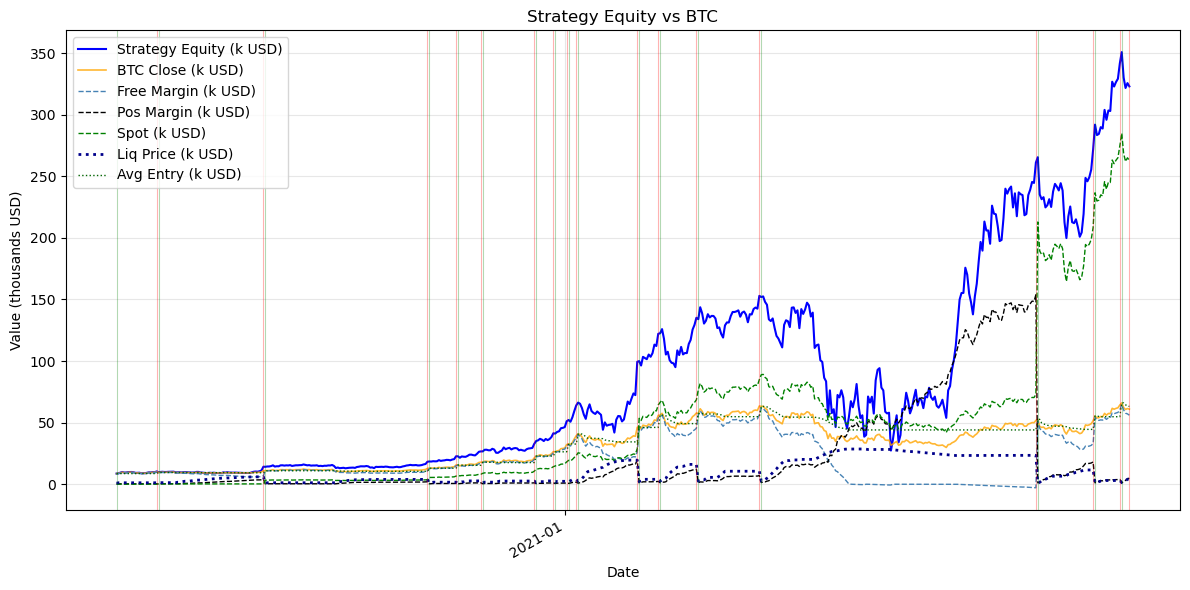

In [7]:
if not perf.empty:
    plt.figure(figsize=(12, 6))
    # Normalize equity and BTC price for a visual compare (scale to thousands for readability)
    plt.plot(perf['Date'], perf['Equity_USD'] / 1000.0, label='Strategy Equity (k USD)', color='blue', linewidth=1.5)
    plt.plot(perf['Date'], perf['Close'] / 1000.0, label='BTC Close (k USD)', color='orange', linewidth=1.2, alpha=0.8)

    # Components
    plt.plot(perf['Date'], (perf['Free_Margin_BTC'] * perf['Close']) / 1000.0,
             '--', label='Free Margin (k USD)', color='steelblue', linewidth=1.0)
    plt.plot(perf['Date'], (perf['Pos_Margin_BTC'] * perf['Close']) / 1000.0,
             '--', label='Pos Margin (k USD)', color='black', linewidth=1.0)
    plt.plot(perf['Date'], (perf['Spot_BTC'] * perf['Close']) / 1000.0,
             '--', label='Spot (k USD)', color='green', linewidth=1.0)

    # Liq and average entry (scaled)
    plt.plot(perf['Date'], perf['Liq_Price'] / 1000.0, ':', label='Liq Price (k USD)', color='darkblue', linewidth=2.0)
    plt.plot(perf['Date'], perf['Avg_Entry'] / 1000.0, ':', label='Avg Entry (k USD)', color='darkgreen', linewidth=1.0)

    # Cycle markers
    for d in status['starts']:
        plt.axvline(d, color='green', alpha=0.3, linewidth=0.8)
    for d in status['ends']:
        plt.axvline(d, color='red', alpha=0.3, linewidth=0.8)

    plt.title('Strategy Equity vs BTC')
    plt.xlabel('Date')
    plt.ylabel('Value (thousands USD)')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()
    

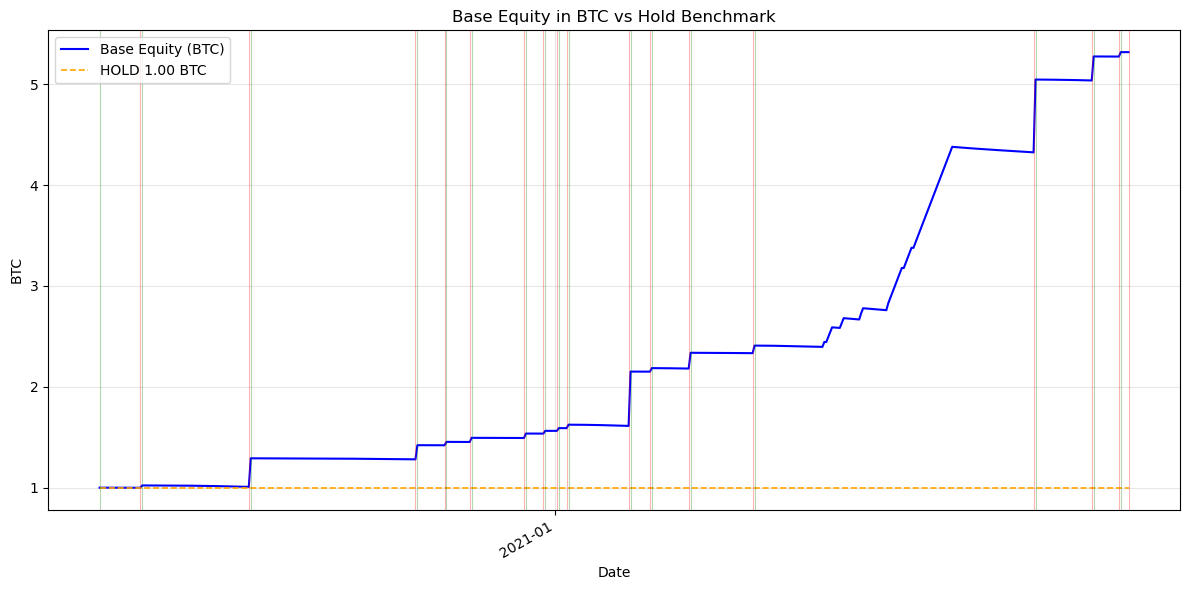

In [8]:
if not perf.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(perf['Date'], perf['Base_Equity_BTC'], label='Base Equity (BTC)', color='blue', linewidth=1.5)
    plt.plot(perf['Date'], np.full(len(perf), cfg.initial_margin_btc), '--', label=f'HOLD {cfg.initial_margin_btc:.2f} BTC', color='orange', linewidth=1.2)

    for d in status['starts']:
        plt.axvline(d, color='green', alpha=0.3, linewidth=0.8)
    for d in status['ends']:
        plt.axvline(d, color='red', alpha=0.3, linewidth=0.8)

    plt.title('Base Equity in BTC vs Hold Benchmark')
    plt.xlabel('Date')
    plt.ylabel('BTC')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [9]:
if cycles:
    print("Cycle Details:")
    print("="*160)
    print(f"{'Cycle':<6} {'Start Date':<12} {'End Date':<12} {'Reason':<16} {'Days':<5} "
          f"{'Start Eq (BTC)':<15} {'End Eq (BTC)':<15} "
          f"{'Start Px':<12} {'End Px':<12} "
          f"{'Start Liq':<12} {'End Liq':<12} "
          f"{'ΔBTC':<12}")
    print("-"*160)
    for cy in cycles:
        if 'end_date' not in cy:
            continue
        start_eq_btc = cy['start_equity_btc_excl_unreal']
        end_eq_btc = cy['end_equity_btc_excl_unreal']
        btc_change = end_eq_btc - start_eq_btc
        start_liq = cy.get('start_liq_price', np.nan)
        end_liq = cy.get('last_liq_price', np.nan)
        print(f"{cy['cycle']:<6} "
              f"{cy['start_date'].strftime('%Y-%m-%d'):<12} "
              f"{cy['end_date'].strftime('%Y-%m-%d'):<12} "
              f"{cy.get('reason',''): <16} "
              f"{cy.get('duration_days',0):<5} "
              f"{start_eq_btc: <15.6f} "
              f"{end_eq_btc: <15.6f} "
              f"{cy['start_price']: <12.2f} "
              f"{cy['end_price']: <12.2f} "
              f"{(start_liq if pd.notna(start_liq) else float('nan')): <12.2f} "
              f"{(end_liq if pd.notna(end_liq) else float('nan')): <12.2f} "
              f"{btc_change:+.6f}")

Cycle Details:
Cycle  Start Date   End Date     Reason           Days  Start Eq (BTC)  End Eq (BTC)    Start Px     End Px       Start Liq    End Liq      ΔBTC        
----------------------------------------------------------------------------------------------------------------------------------------------------------------
1      2020-05-11   2020-06-01   TAKE-PROFIT      21    0.999960        1.022151        8602.23      10166.76     785.96       1128.50      +0.022191
2      2020-06-02   2020-07-27   TAKE-PROFIT      55    1.022111        1.291102        9530.28      10990.32     853.56       5964.24      +0.268991
3      2020-07-28   2020-10-21   TAKE-PROFIT      85    1.291062        1.421165        10913.37     12823.05     788.46       3866.95      +0.130103
4      2020-10-22   2020-11-05   TAKE-PROFIT      14    1.421125        1.453923        12966.54     15579.07     856.69       1607.41      +0.032798
5      2020-11-06   2020-11-18   TAKE-PROFIT      12    1.453883       

In [10]:
def make_cfg(base_cfg: StrategyConfig, **overrides) -> StrategyConfig:
    # Create a copy with selected overrides
    params = base_cfg.__dict__.copy()
    params.update(overrides)
    return StrategyConfig(**params)

# Define a compact but meaningful grid. Keep it small to avoid overfitting and runtime blowups.
param_grid = {
    'leverage_limit': [2, 2.5, 3, 3.5, 4, 5, 6, 7, 8, 9, 10],
    'take_profit_pct': [0.04, 0.05, 0.06, 0.08, 0.10],
    'open_margin_pct': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    # Optional cost sensitivity (uncomment to include)
    # 'commission_rate': [0.0002, 0.0004, 0.0006],
    # 'slippage_bps': [0.2, 0.5, 1.0],
}

def grid_sweep(price_df: pd.DataFrame,
               base_cfg: StrategyConfig,
               param_grid: dict,
               primary_metric: str = 'Sharpe (Lo-Adj)',
               secondary_metric: str = 'CAGR (%)',
               penalty_on_dd: bool = False) -> pd.DataFrame:
    """
    Run a grid search over param_grid on price_df using base_cfg as defaults.
    Returns a DataFrame sorted by (primary_metric desc, secondary_metric desc).
    Optionally apply a soft penalty on large drawdowns in ranking.
    """
    keys = list(param_grid.keys())
    combos = list(product(*[param_grid[k] for k in keys]))
    rows = []

    for combo in combos:
        overrides = dict(zip(keys, combo))
        cfg = make_cfg(base_cfg, **overrides)
        res = run_backtest(price_df, cfg)
        perf = res['perf']
        summ = summarize_performance(perf)

        # Guard for empty or degenerate runs
        if not summ:
            continue

        rank_primary = summ.get(primary_metric, np.nan)
        rank_secondary = summ.get(secondary_metric, np.nan)
        max_dd = summ.get('Max Drawdown (%)', np.nan)

        # Optional: penalize large drawdowns in the ranking number (softly)
        if penalty_on_dd and not np.isnan(rank_primary) and not np.isnan(max_dd):
            # Example: subtract 0.005 * |MaxDD| from primary metric (tune as desired)
            rank_primary = rank_primary - 0.005 * abs(max_dd)

        row = {**overrides,
               'IS_' + primary_metric: rank_primary,
               'IS_' + secondary_metric: rank_secondary,
               'IS_Max Drawdown (%)': max_dd,
               'IS_Total Return (%)': summ.get('Total Return (%)', np.nan),
               'IS_Final Equity (USD)': summ.get('Final Equity (USD)', np.nan),
               'IS_Liquidated': res['status']['liquidated']}
        rows.append(row)

    results = pd.DataFrame(rows)
    if results.empty:
        print("No results from grid sweep.")
        return results

    results = results.sort_values(
        by=[f'IS_{primary_metric}', f'IS_{secondary_metric}'],
        ascending=[False, False]
    ).reset_index(drop=True)
    return results

# Run the grid sweep on IS
base_cfg = StrategyConfig(
    initial_margin_btc=1.0,
    leverage_limit=1.2,          # default; will be overridden by grid
    open_margin_pct=0.02,
    take_profit_pct=0.10,
    commission_rate=0.0004,
    slippage_bps=0.5,
    constant_funding_daily=0.10 / 365.0,
    maintenance_margin_rate=0.005,
    stop_on_liquidation=True,
    forced_close_on_last_day=True,
    deterministic_fills=True
)

price_is = price.copy()  # the entire IS window

grid_results_is = grid_sweep(
    price_df=price_is,
    base_cfg=base_cfg,
    param_grid=param_grid,
    primary_metric='Sharpe (Lo-Adj)',
    secondary_metric='CAGR (%)',
    penalty_on_dd=True  # softly prefer lower DD
)
grid_results_is

,leverage_limit,take_profit_pct,open_margin_pct,IS_Sharpe (Lo-Adj),IS_CAGR (%),IS_Max Drawdown (%),IS_Total Return (%),IS_Final Equity (USD),IS_Liquidated
0,2.0,0.10,0.06,2.282479,904.770549,-61.281888,2769.468297,246804.362490,False
1,2.0,0.10,0.05,2.270820,883.465696,-60.813046,2681.382180,239231.497008,False
2,2.0,0.08,0.06,2.266946,956.284320,-60.487292,2985.963223,265425.196222,False
3,2.0,0.08,0.05,2.265447,947.322477,-60.294521,2947.947005,262159.199090,False
4,2.0,0.08,0.04,2.256891,939.345086,-60.181604,2914.231039,259262.984789,False
...,...,...,...,...,...,...,...,...,...
325,6.0,0.04,0.01,0.972498,144.710242,-84.884184,171.252509,23331.573650,True
326,7.0,0.04,0.01,0.962933,125.862185,-88.298012,148.061729,21336.682231,True
327,9.0,0.10,0.01,0.954513,138.733673,-88.136804,155.213897,21951.548060,True
328,10.0,0.10,0.01,0.931207,118.591696,-89.945998,132.106738,19963.902418,True


Best IS parameters: {'leverage_limit': 2.0, 'take_profit_pct': 0.1, 'open_margin_pct': 0.06}

Best Params — IS Performance
Initial Equity (USD): $8,601.05
Final Equity (USD): $246,804.36
Total Return (%): 2769.4683
CAGR (%): 904.7705
Sharpe: 2.5889
Sharpe (Lo-Adj): 2.5889
Sortino: 3.7300
Max Drawdown (%): -61.2819
Max DD Duration (days): 102
Calmar: 14.7641
VaR 95% (1d, %): -7.5123
ES 95% (1d, %): -12.9548

Best Params — OOS Performance
Initial Equity (USD): $64,988.79
Final Equity (USD): $82,100.03
Total Return (%): 26.3295
CAGR (%): 59.3878
Sharpe: 0.9740
Sharpe (Lo-Adj): 0.9740
Sortino: 1.6364
Max Drawdown (%): -50.2535
Max DD Duration (days): 81
Calmar: 1.1818
VaR 95% (1d, %): -10.3342
ES 95% (1d, %): -13.1279


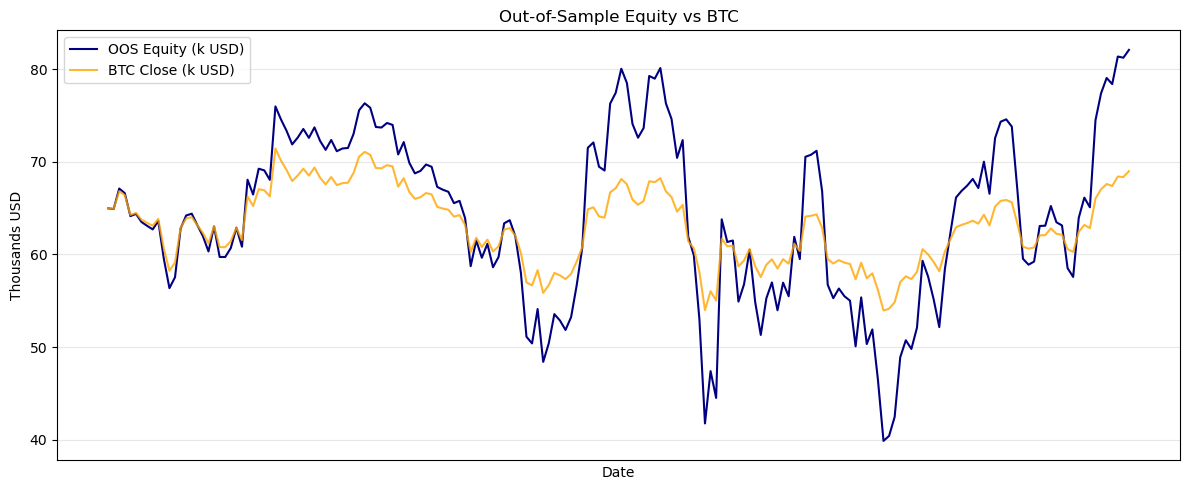

In [11]:
def pick_best_params(grid_df: pd.DataFrame) -> dict:
    if grid_df.empty:
        raise ValueError("Empty grid results; cannot pick best parameters.")
    # First row is best under our sort order
    keys = [k for k in grid_df.columns if k in param_grid.keys()]
    return grid_df.iloc[0][keys].to_dict()

if grid_results_is.empty:
    print("Grid results empty; cannot proceed to OOS.")
else:
    best_params = pick_best_params(grid_results_is)
    print("Best IS parameters:", best_params)

    # Evaluate on OOS (fresh run with same params)
    best_cfg_oos = make_cfg(base_cfg, **best_params)
    res_oos = run_backtest(price_oos, best_cfg_oos)
    perf_oos = res_oos['perf']
    summary_oos = summarize_performance(perf_oos)

    # For reference, also capture IS performance of best params (not the whole grid)
    best_cfg_is = make_cfg(base_cfg, **best_params)
    res_is_best = run_backtest(price_is, best_cfg_is)
    perf_is_best = res_is_best['perf']
    summary_is_best = summarize_performance(perf_is_best)

    print("\nBest Params — IS Performance")
    for k, v in summary_is_best.items():
        if isinstance(v, float):
            if 'Equity' in k:
                print(f"{k}: ${v:,.2f}")
            else:
                print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

    print("\nBest Params — OOS Performance")
    if not summary_oos:
        print("OOS period empty or invalid.")
    else:
        for k, v in summary_oos.items():
            if isinstance(v, float):
                if 'Equity' in k:
                    print(f"{k}: ${v:,.2f}")
                else:
                    print(f"{k}: {v:.4f}")
            else:
                print(f"{k}: {v}")

    # Optional: plot OOS equity
    if perf_oos is not None and not perf_oos.empty:
        plt.figure(figsize=(12, 5))
        plt.plot(perf_oos['Date'], perf_oos['Equity_USD'] / 1000.0, label='OOS Equity (k USD)', color='navy')
        plt.plot(perf_oos['Date'], perf_oos['Close'] / 1000.0, label='BTC Close (k USD)', color='orange', alpha=0.8)
        plt.title('Out-of-Sample Equity vs BTC')
        plt.xlabel('Date')
        plt.ylabel('Thousands USD')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()

### 9) Limitations & assumptions

- Liquidation formula is a simplified approximation (exchange-specific details vary)
- Funding defaults to a constant daily rate unless a historical series is provided
- Daily bars only; intraday path dependency (gap risk) is not modeled
- Close-based fills by default; T+1 execution can be enabled to remove look-ahead

### 10) Reproducibility & outputs

- Environment: Python 3.10+, NumPy, pandas, Matplotlib (see requirements.txt)
- Deterministic: no randomness in fills; results should be repeatable with same data
- Saved artifacts:
  - figures/: equity curve and drawdown plots (PNG)
  - results/: summary tables (CSV) for IS and OOS
- Data note: If BTC-USD_Historical.csv is absent, run the optional download cell to create it